In [ ]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import catboost
import xgboost as xgb


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Считаем данные**

In [4]:
data = pd.read_csv("drive/My Drive/Colab Notebooks/Данные для задачи - Ренессанс.txt", sep = ';')

**Изучим типы данных и пропуски**

In [5]:
def isnumeric(obj):
    try:
        obj + 0
        return True
    except TypeError:
        return False

In [6]:
def get_columns_with_nonnumeric_values(df):
  for c, t in zip(df.columns, df.dtypes):
    f = df[c].apply(lambda x: not isnumeric(x))
    if f.sum():
      print('column:', c)

In [7]:
def get_columns_with_missing_values(df):
  for c in df.columns:
    cnt_miss = np.sum(df[c].isna())
    if cnt_miss:
      print('column:', c, ' missing values count:', cnt_miss)

In [8]:
get_columns_with_missing_values(data)

In [9]:
get_columns_with_nonnumeric_values(data)

column: DATA_TYPE
column: POLICY_BRANCH
column: VEHICLE_MAKE
column: VEHICLE_MODEL
column: POLICY_INTERMEDIARY
column: INSURER_GENDER
column: POLICY_CLM_N
column: POLICY_CLM_GLT_N
column: POLICY_PRV_CLM_N
column: POLICY_PRV_CLM_GLT_N
column: POLICY_YEARS_RENEWED_N
column: CLIENT_REGISTRATION_REGION


**Бинарный признак для POLICY_BRANCH**

In [10]:
data['POLICY_BRANCH'].unique()

array(['Москва', 'Санкт-Петербург'], dtype=object)

In [11]:
data['POLICY_BRANCH'] = data['POLICY_BRANCH'].map({'Москва': 1, 'Санкт-Петербург': 0})

**Бинарный признак для INSURER_GENDER**

In [12]:
data['INSURER_GENDER'].unique()

array(['F', 'M'], dtype=object)

In [13]:
data['INSURER_GENDER'] = data['INSURER_GENDER'].map({'M': 1, 'F': 0})

**Rank для POLICY_CLM_N**

In [14]:
len(data[(data['POLICY_CLM_N'] == 'n/d') & (data['POLICY_PRV_CLM_N'] != 'N')]), len(data[(data['POLICY_CLM_N'] == 'n/d') & ~(data['POLICY_YEARS_RENEWED_N'].isin(['0', 'N']))])

(0, 0)

Т.е. 'n/d', видимо, означает, что данных нет именно по причине, что полис оформлен впервые.

Ясно, что можно применить OneHot для POLOCY_CLM_N, однако лучше использовать всю информацию - зададим условный ранг для числа убытка (и его объёма) - чем больше ранг, тем больше убыток.  
Аналогично проделаем и для остальных типов убытков.

In [15]:
def get_rank(x: str) -> int:
  if x == '0' or x == 'n/d' or x == 'N':
    return 0
  elif x == '1S':
    return 1
  elif x == '1L':
    return 2
  elif x =='2':
    return 3
  elif x =='3':
    return 4
  elif x =='4+':
    return 5 
  else:
    raise Exception('unknown case')

In [16]:
data['POLICY_CLM_N'].value_counts()

0      68111
1S     10071
1L      9923
2       6155
3       1708
4+       581
n/d       56
Name: POLICY_CLM_N, dtype: int64

In [17]:
data['POLICY_CLM_N'] = data['POLICY_CLM_N'].apply(get_rank)

**Rank для POLICY_CLM_GLT_N**

In [18]:
data['POLICY_CLM_GLT_N'].unique()

array(['0', '1S', '2', '1L', '4+', '3', 'n/d'], dtype=object)

In [19]:
data['POLICY_CLM_GLT_N'] = data['POLICY_CLM_GLT_N'].apply(get_rank)

**Rank для POLICY_PRV_CLM_N**

In [20]:
data['POLICY_PRV_CLM_N'].value_counts()

0     44587
N     33305
1S     7261
1L     6790
2      3746
3       788
4+      128
Name: POLICY_PRV_CLM_N, dtype: int64

In [21]:
data['POLICY_PRV_CLM_N'] = data['POLICY_PRV_CLM_N'].apply(get_rank)

**Rank для POLICY_PRV_CLM_GLT_N**

In [22]:
data['POLICY_PRV_CLM_GLT_N'].unique()

array(['N', '0', '1L', '1S', '2', '3', '4+'], dtype=object)

In [23]:
data['POLICY_PRV_CLM_GLT_N'] = data['POLICY_PRV_CLM_GLT_N'].apply(get_rank)

**Приведём данные в признаке POLICY_INTERMEDIARY к целому типу. Пропуск 'N' заменим на 0**


In [24]:
data['POLICY_INTERMEDIARY'].unique()

array(['856', 'N', '171', ..., '1306', '942', '930'], dtype=object)

In [25]:
'0' in data['POLICY_INTERMEDIARY'].unique()

False

In [26]:
data['POLICY_INTERMEDIARY'] = data['POLICY_INTERMEDIARY'].replace('N', '0')
data['POLICY_INTERMEDIARY'] = data['POLICY_INTERMEDIARY'].apply(lambda x: int(x))

In [27]:
d = data['POLICY_INTERMEDIARY'].value_counts().sort_values()
d[-10:]

1221     1228
1200     1254
493      1270
343      1304
171      1310
326      1373
1252     2310
910      3663
1096    11187
0       20630
Name: POLICY_INTERMEDIARY, dtype: int64

Видно, что 2 посредника сильно выделяются. Сделаем OneHot top3. 

In [28]:
data['POLICY_INTERMEDIARY'] = data['POLICY_INTERMEDIARY'].apply(lambda x: x if x in (0, 1096, 910) else 'rest')

In [29]:
data = data.join(pd.get_dummies(data['POLICY_INTERMEDIARY'], prefix = 'POLICY_INTERMEDIARY_'))
data = data.drop(columns = ['POLICY_INTERMEDIARY'])

**POLICY_YEARS_RENEWED_N**

Оставим, как есть, но N заменим на 0. OneHot сделать можно, но не хочется, т.к. порядок для количества лет пролонгации полиса задан - чем больше, тем лучше.

In [30]:
data['POLICY_YEARS_RENEWED_N'].value_counts()

0     33249
1     25299
2     15278
3     11496
4      6215
5      2228
6      1748
7       832
8       104
9        82
N        56
10       18
Name: POLICY_YEARS_RENEWED_N, dtype: int64

In [31]:
data['POLICY_YEARS_RENEWED_N'] = data['POLICY_YEARS_RENEWED_N'].apply(lambda x: 0 if x =='N' else int(x))

In [32]:
data['POLICY_YEARS_RENEWED_N'].unique()

array([ 0,  4,  1,  6,  3,  2,  7,  5, 10,  8,  9])

In [33]:
data[data['POLICY_IS_RENEWED'] == 1].groupby(by = ['POLICY_YEARS_RENEWED_N']).count()

DATA_TYPE  ...  POLICY_INTERMEDIARY__rest
POLICY_YEARS_RENEWED_N             ...                           
0                           14177  ...                      14177
1                           13667  ...                      13667
2                            7928  ...                       7928
3                            6310  ...                       6310
4                            3342  ...                       3342
5                            1319  ...                       1319
6                            1021  ...                       1021
7                             481  ...                        481
8                              69  ...                         69
9                              49  ...                         49
10                             13  ...                         13

[11 rows x 32 columns]

Добавим onehot признаки с числом пролонгации. Понятно, что вероятность того, что клиент пролонгирует вновь, зависит от числа пролонгаций ранее: при малом числе лет вероятность большая, при большом числе лет - снижается.

In [34]:
data['POLICY_YEARS_RENEWED_N_2'] = data['POLICY_YEARS_RENEWED_N'].apply(lambda x: 1 if x <= 2 else 0)
data['POLICY_YEARS_RENEWED_N_3'] = data['POLICY_YEARS_RENEWED_N'].apply(lambda x: 1 if x <= 3 else 0)
data['POLICY_YEARS_RENEWED_N_4'] = data['POLICY_YEARS_RENEWED_N'].apply(lambda x: 1 if x <= 4 else 0)

**OneHot top4 для CLIENT_REGISTRATION_REGION**

In [35]:
def change_region(region_name):
  if region_name in ('Санкт-Петербург', 'Москва', 'Московская', 'Ленинградская'):
    return region_name
  else:
    return 'Остальное'

In [36]:
data['CLIENT_REGISTRATION_REGION'] = data['CLIENT_REGISTRATION_REGION'].apply(change_region)

In [37]:
d = data['CLIENT_REGISTRATION_REGION'].value_counts()
d.sort_values()

Остальное           4634
Ленинградская       5877
Московская         12820
Москва             34420
Санкт-Петербург    38854
Name: CLIENT_REGISTRATION_REGION, dtype: int64

In [38]:
data = data.join(pd.get_dummies(data['CLIENT_REGISTRATION_REGION'], prefix = 'CLIENT_REGISTRATION_REGION_'))
data = data.drop(columns = ['CLIENT_REGISTRATION_REGION'])

**VEHICLE_ENGINE_POWER**

In [39]:
len(data['VEHICLE_ENGINE_POWER'].unique())

347

In [40]:
data['VEHICLE_ENGINE_POWER'].sort_values()[:20]

29667     0.0
88367     0.0
72065     0.0
82578     0.0
456       0.0
32000     0.0
82434     0.0
9446      0.0
57814     0.0
78186     0.0
92908     0.0
67018     0.0
59522     0.0
73368     0.0
65810     0.0
52598     0.0
61466     0.0
3567     51.0
15924    51.0
58373    51.0
Name: VEHICLE_ENGINE_POWER, dtype: float64

Данные восстановить не удастся точно. Тогда восстановим средним по той же марки и типу ТС. Прицепы оставим в покое.

In [41]:
data[data['VEHICLE_ENGINE_POWER'] == 0][['VEHICLE_MAKE', 'VEHICLE_MODEL']]

VEHICLE_MAKE                                   VEHICLE_MODEL
456      Другая марка (Иностранного производства)                         Другая модель (Автобус)
9446                                       Scania                     Другая модель (Грузовое ТС)
29667                                         Jcb          Другая модель (Тракторы и спецтехника)
32000                                      Купава  Другая модель (Прицепы к грузовым автомобилям)
52598                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
57814                                         ИПВ  Другая модель (Прицепы к грузовым автомобилям)
59522    Другая марка (Иностранного производства)  Другая модель (Прицепы к грузовым автомобилям)
61466                                     Hyundai                     Другая модель (Грузовое ТС)
65810  Другая марка (Отечественного производства)  Другая модель (Прицепы к грузовым автомобилям)
67018                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
72065                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
73368                                       Kogel  Другая модель (Прицепы к грузовым автомобилям)
78186                                       КАМАЗ                     Другая модель (Грузовое ТС)
82434                                       Krone  Другая модель (Прицепы к грузовым автомобилям)
82578                                  Mitsubishi                     Другая модель (Грузовое ТС)
88367                                         МАЗ                     Другая модель (Грузовое ТС)
92908                                         Jcb          Другая модель (Тракторы и спецтехника)

In [42]:
for index, row in data[(data['VEHICLE_ENGINE_POWER'] == 0) & (data['VEHICLE_MODEL'] != 'Другая модель (Прицепы к грузовым автомобилям)')].iterrows():
  avg = data[(data['VEHICLE_ENGINE_POWER'] != 0) & (data['VEHICLE_MAKE'] == row['VEHICLE_MAKE']) & (data['VEHICLE_MODEL'] == row['VEHICLE_MODEL'])]['VEHICLE_ENGINE_POWER'].mean()
  if avg is np.nan:
    avg = data[(data['VEHICLE_ENGINE_POWER'] != 0) & (data['VEHICLE_MODEL'] == row['VEHICLE_MODEL'])]['VEHICLE_ENGINE_POWER'].mean()
  row['VEHICLE_ENGINE_POWER'] = avg
  data.loc[index] = row

In [43]:
data[data['VEHICLE_ENGINE_POWER'] == 0][['VEHICLE_MAKE', 'VEHICLE_MODEL']]

VEHICLE_MAKE                                   VEHICLE_MODEL
32000                                      Купава  Другая модель (Прицепы к грузовым автомобилям)
52598                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
57814                                         ИПВ  Другая модель (Прицепы к грузовым автомобилям)
59522    Другая марка (Иностранного производства)  Другая модель (Прицепы к грузовым автомобилям)
65810  Другая марка (Отечественного производства)  Другая модель (Прицепы к грузовым автомобилям)
67018                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
72065                                     Wielton  Другая модель (Прицепы к грузовым автомобилям)
73368                                       Kogel  Другая модель (Прицепы к грузовым автомобилям)
82434                                       Krone  Другая модель (Прицепы к грузовым автомобилям)

**Признак VEHICLE_MAKE**

In [44]:
d = data['VEHICLE_MAKE'].value_counts().sort_values()

In [45]:
d[-20:]

Subaru            1134
Mazda             1225
Mercedes-Benz     1272
Chevrolet         1306
Suzuki            1611
Land Rover        1674
Volvo             1744
Opel              1789
Honda             1833
Audi              2195
Skoda             4054
BMW               4744
Volkswagen        5178
Nissan            6514
Mitsubishi        7169
Ford              8127
Renault           8733
Toyota            8866
Hyundai           9168
Kia              11050
Name: VEHICLE_MAKE, dtype: int64

Возможно, марка ТС влияет на факт пролонгации. Возьмём OneHot top7.

In [46]:
top7 = d.sort_values()[-7:]

In [47]:
top7

Nissan         6514
Mitsubishi     7169
Ford           8127
Renault        8733
Toyota         8866
Hyundai        9168
Kia           11050
Name: VEHICLE_MAKE, dtype: int64

In [48]:
def change_vehicle(vehicle):
  if vehicle in top7:
    return vehicle
  else:
    return 'Остальное'

In [49]:
data['VEHICLE_MAKE'] = data['VEHICLE_MAKE'].apply(change_vehicle)
data = data.join(pd.get_dummies(data['VEHICLE_MAKE'], prefix = 'VEHICLE_MAKE_'))
data = data.drop(columns = ['VEHICLE_MAKE'])

**Признак VEHICLE_MODEL_RATIO - доля моделей машин данного типа**

In [50]:
d = data['VEHICLE_MODEL'].value_counts()

In [51]:
d

RAV4             4186
Sportage         3692
Duster           3612
Focus            3196
ix35             2971
                 ... 
Fora (A21)          1
SC                  1
V60                 1
Xsara Picasso       1
Magentis            1
Name: VEHICLE_MODEL, Length: 549, dtype: int64

Скорее всего, мало содержательности, какой модели данное ТС. Введём новый признак, показывающий долю данной модели среди всех моделей.

In [52]:
data['VEHICLE_MODEL_RATIO'] = data['VEHICLE_MODEL'].apply(lambda x: d[x] / len(data))
data = data.drop(columns = ['VEHICLE_MODEL'])

**OneHot для числа месяцев действия полиса**

In [53]:
data['POLICY_END_MONTH'].unique()

array([ 1,  2, 11, 12,  3,  8,  9,  4, 10,  7,  5,  6])

In [54]:
diff = data['POLICY_END_MONTH'] - data['POLICY_BEGIN_MONTH']

In [55]:
diff = diff.apply(lambda x: x + 12 if x <=0 else x)

In [56]:
data['MONTH_AMOUNT'] = diff.values

In [57]:
data['MONTH_AMOUNT'].unique(), np.sum(data['MONTH_AMOUNT'].isna())

(array([12, 11,  6,  8,  7, 10,  5,  9]), 0)

Есть пропуски. Заполним их медианой

In [58]:
med = data['MONTH_AMOUNT'].median()
data['MONTH_AMOUNT'] = data['MONTH_AMOUNT'].fillna(med)

In [59]:
data['MONTH_AMOUNT'].value_counts()

12    94271
11     2290
6        29
7         8
8         4
10        1
9         1
5         1
Name: MONTH_AMOUNT, dtype: int64

Заметим, что значимая часть равна 12. Разобъём на категории: 12 месяцев, 11 месяцев, <=10 месяцев.  
Признаки POLICY_BEGIN_MONTH и POLICY_END_MONTH удалим, т.к. они неинформативны (сезон года не должен сильно влиять на пролонгацию)

In [60]:
data['MONTH_AMOUNT_12'] = data['MONTH_AMOUNT'].apply(lambda x: 1 if x == 12 else 0)
data['MONTH_AMOUNT_11'] = data['MONTH_AMOUNT'].apply(lambda x: 1 if x == 11 else 0)
data['MONTH_AMOUNT_<=10'] = data['MONTH_AMOUNT'].apply(lambda x: 1 if x <= 10 else 0)
data = data.drop(columns = ['MONTH_AMOUNT'])

In [61]:
data = data.drop(columns = ['POLICY_BEGIN_MONTH', 'POLICY_END_MONTH'])

**OneHot top4 для POLICY_SALES_CHANNEL**

In [62]:
np.sum(data['POLICY_SALES_CHANNEL'].isna())

0

In [63]:
data['POLICY_SALES_CHANNEL'].unique()

array([39, 50, 52,  2, 10, 53, 54,  1,  6, 55, 17, 20, 37, 23, 29, 59, 15,
        8, 40, 41, 14, 11, 62, 60, 46,  5, 22, 31, 51,  3, 16, 25, 27, 63,
       45,  4, 13, 18, 26, 44, 28,  7,  9, 47, 49, 38, 35, 12, 57, 21, 19,
       43, 24, 34, 30, 32, 33, 42, 61, 36, 48, 58, 56])

In [64]:
d = data['POLICY_SALES_CHANNEL'].value_counts()
d.sort_values()

56        1
38        2
58        7
30       14
61       15
      ...  
54     4897
55    11397
50    16176
53    21070
52    24728
Name: POLICY_SALES_CHANNEL, Length: 63, dtype: int64

In [65]:
def change_POLICY_SALES_CHANNEL(x):
  if x in (52, 53, 50, 55):
    return x
  else:
    return 'Остальное'

In [66]:
data['POLICY_SALES_CHANNEL'] = data['POLICY_SALES_CHANNEL'].apply(change_POLICY_SALES_CHANNEL)
data = data.join(pd.get_dummies(data['POLICY_SALES_CHANNEL'], prefix ='POLICY_SALES_CHANNEL_'))
data = data.drop(columns = ['POLICY_SALES_CHANNEL'])

**OneHot top5 для POLICY_SALES_CHANNEL_GROUP**

In [67]:
data['POLICY_SALES_CHANNEL_GROUP'].unique()

array([1, 5, 6, 4, 3, 8, 2, 7])

In [68]:
d = data['POLICY_SALES_CHANNEL_GROUP'].value_counts()
d.sort_values()

7       24
2      200
8      420
3     3621
4     4211
1     9860
5    16176
6    62093
Name: POLICY_SALES_CHANNEL_GROUP, dtype: int64

In [69]:
top5 = d.sort_values()[-8:]

In [70]:
def change_POLICY_SALES_CHANNEL_GROUP(x):
  if x in top5:
    return x
  else:
    return 'Остальное'

In [71]:
data['POLICY_SALES_CHANNEL_GROUP'] = data['POLICY_SALES_CHANNEL_GROUP'].apply(change_POLICY_SALES_CHANNEL_GROUP)
data = data.join(pd.get_dummies(data['POLICY_SALES_CHANNEL_GROUP'], prefix ='POLICY_SALES_CHANNEL_GROUP_'))
data = data.drop(columns = ['POLICY_SALES_CHANNEL_GROUP'])

**VEHICLE_IN_CREDIT**

In [72]:
data['VEHICLE_IN_CREDIT'].value_counts()

0    65503
1    31102
Name: VEHICLE_IN_CREDIT, dtype: int64

**VEHICLE_SUM_INSURED**

In [73]:
d = data['VEHICLE_SUM_INSURED'].value_counts()
d

900000.0     481
1000000.0    440
800000.0     384
500000.0     374
700000.0     371
            ... 
994990.0       1
1203544.0      1
732837.0       1
601754.0       1
588200.0       1
Name: VEHICLE_SUM_INSURED, Length: 44638, dtype: int64

**CLIENT_HAS_DAGO**

In [74]:
data['CLIENT_HAS_DAGO'].value_counts()

0    69799
1    26806
Name: CLIENT_HAS_DAGO, dtype: int64

**CLIENT_HAS_OSAGO**

In [75]:
data['CLIENT_HAS_OSAGO'].value_counts()

1    53162
0    43443
Name: CLIENT_HAS_OSAGO, dtype: int64

Также добавим признак, что у клиента есть хотя бы один вид страховки

In [76]:
data['CLIENT_HAS_DAGO_OR_OSAGO'] = data['CLIENT_HAS_DAGO'] + data['CLIENT_HAS_OSAGO']
data['CLIENT_HAS_DAGO_OR_OSAGO'] = data['CLIENT_HAS_DAGO_OR_OSAGO'].apply(lambda x: int(x > 0))

**POLICY_COURT_SIGN**

In [77]:
data['POLICY_COURT_SIGN'].value_counts()

0    96507
1       98
Name: POLICY_COURT_SIGN, dtype: int64

**CLAIM_AVG_ACC_ST_PRD**

In [78]:
len(data['CLAIM_AVG_ACC_ST_PRD'].unique())

709

**POLICY_HAS_COMPLAINTS**

In [79]:
data['POLICY_HAS_COMPLAINTS'].value_counts()

0    95865
1      740
Name: POLICY_HAS_COMPLAINTS, dtype: int64

**POLICY_DEDUCT_VALUE**

In [80]:
len(data['POLICY_DEDUCT_VALUE'].unique())

235

**POLICY_PRICE_CHANGE**

In [81]:
len(data['POLICY_PRICE_CHANGE'].unique())

592

Добавим признак POLICY_PRICE_CHANGE_POSITIVE: цена пролонгации выросла. Аналогично для снижения

In [82]:
data['POLICY_PRICE_CHANGE_POSITIVE'] = data['POLICY_PRICE_CHANGE'].apply(lambda x: int(x > 0))

In [83]:
data['POLICY_PRICE_CHANGE_NEGATIVE'] = data['POLICY_PRICE_CHANGE'].apply(lambda x: int(x < 0))

**POLICY_MIN_AGE**

In [84]:
data['POLICY_MIN_AGE'].unique()

array([51, 35, 41, 36, 42, 60, 48, 27, 56, 38, 53, 30, 39, 64, 47, 61, 44,
       40, 49, 50, 31, 32, 33, 62, 28, 46, 58, 26, 63, 37, 34, 25, 29, 24,
       65, 45, 66, 54, 55, 23, 52, 57, 67, 43, 59, 69, 78, 68, 75, 22, 18,
       76, 74, 80, 72, 19, 73, 77, 71, 20, 79, 70, 21, 86, 82, 81, 83, 84])

**OneHot для POLICY_MIN_DRIVING_EXPERIENCE**

In [85]:
data['POLICY_MIN_DRIVING_EXPERIENCE'].unique()

array([  12,    7,    6,    5,   40,   19,   37,   18,   35,    8,   16,
         11,   45,   20,   17,   25,   13,   15,   28,   29,    2,   42,
          3,   36,    9,   10,   44,   14,   23,   43,   34,   21,   26,
          4,   32,   22,    1,   30,   31,   24,   27,    0,   48, 1986,
         47,   33,   39, 1988,   52,   41, 2008, 2002, 1996, 1995, 1991,
         38, 1993, 1979,   46,   50, 1994, 2014, 1968, 2004, 1998, 1999,
       1980,   49, 1984, 2006,   58, 2000, 1992, 1990, 1976, 1989,   51,
       1974,   55, 2003, 1997, 1981, 2007, 1973, 2005, 2010, 2011, 1983,
       2013,   53, 1987, 1969, 2009, 2001,   54, 1982,   60, 1975, 1985,
       1965, 1978, 1977, 2015, 2012, 1962,   57, 1956, 1972,   56, 1970,
       1958, 1963])

Есть засорённые данные, где указан год, а не опыт. Подправим данные

In [86]:
data['POLICY_MIN_DRIVING_EXPERIENCE'] = data['POLICY_MIN_DRIVING_EXPERIENCE'].apply(lambda x: 2020 - x if x>100 else 0)

In [87]:
data['POLICY_MIN_DRIVING_EXPERIENCE'].value_counts().sort_values()[-15:]

27       32
17       33
14       34
19       37
16       37
29       38
26       38
18       40
24       45
25       50
23       52
22       54
20       54
21       62
0     95613
Name: POLICY_MIN_DRIVING_EXPERIENCE, dtype: int64

In [88]:
data['POLICY_MIN_DRIVING_EXPERIENCE'].value_counts().sort_values()[-15:]

27       32
17       33
14       34
19       37
16       37
29       38
26       38
18       40
24       45
25       50
23       52
22       54
20       54
21       62
0     95613
Name: POLICY_MIN_DRIVING_EXPERIENCE, dtype: int64

Признак неинформативный. Удалим его

In [89]:
data = data.drop(columns = ['POLICY_MIN_DRIVING_EXPERIENCE'])

**Получим train и test**

In [90]:
train = data[data['DATA_TYPE'] == 'TRAIN'].drop(columns = ['DATA_TYPE'])
test = data[data['DATA_TYPE'] == 'TEST '].drop(columns = ['DATA_TYPE'])

In [91]:
len(train) + len(test) == len(data)

True

Для CV возьмём 4/5 обучающей выборки. val используем для дополнительной проверки оценки качества (т.е. обучаемся на X_train, проверяем качество через CV на X_train и X_val, предсказываем на X_test)

In [92]:
np.random.seed(0)

train_size = 4 * len(train) // 5

indices = np.random.choice(train.index, size = len(train), replace = False)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

In [93]:
X_train = train.drop(columns = ['POLICY_IS_RENEWED', 'POLICY_ID']).loc[train_indices]
y_train = train['POLICY_IS_RENEWED'].loc[train_indices]

X_val = train.drop(columns = ['POLICY_IS_RENEWED', 'POLICY_ID']).loc[val_indices]
y_val = train['POLICY_IS_RENEWED'].loc[val_indices]

X_test = test.drop(columns = ['POLICY_IS_RENEWED', 'POLICY_ID'])

In [94]:
y_train.value_counts()

1    38762
0    23163
Name: POLICY_IS_RENEWED, dtype: int64

**RandomForestClassifier**

In [95]:
def get_predicts(clf, treshold, X):
    y_prob = clf.predict_proba(X)
    y_preds = np.zeros(len(y_prob), dtype = int)
    for i in range(len(y_prob)):
        if y_prob[i][0] > treshold:
            y_preds[i] = -1
        else:
            y_preds[i] = 1
    return y_preds

In [96]:
%%time

clf = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=5, max_features=13)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_val)

CPU times: user 15.4 s, sys: 65.2 ms, total: 15.4 s
Wall time: 15.5 s


In [97]:
print('train:\t val:')
accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_val, y_preds)

train:	 val:


(0.689059345983044, 0.6827929208112647)

Выведем важность признаков

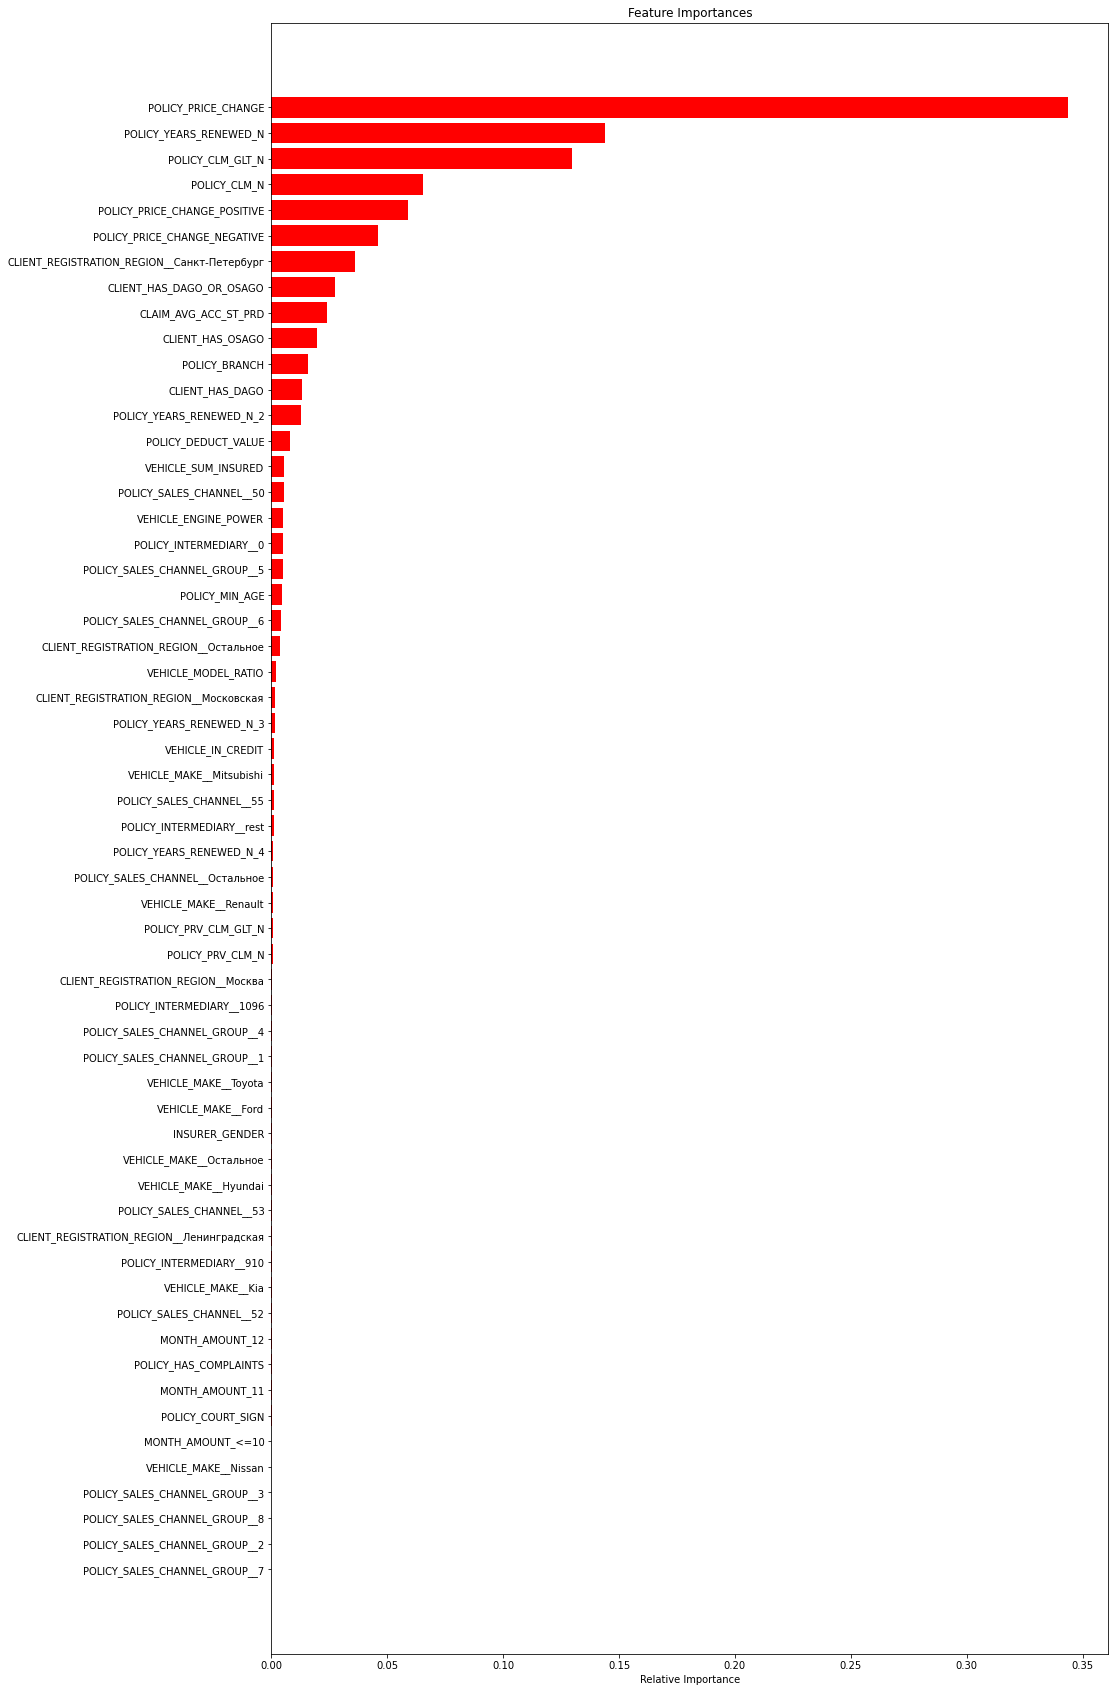

In [98]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Как видно, наиболее важными являются признаки:

      ['VEHICLE_SUM_INSURED',
      'POLICY_DEDUCT_VALUE',
      'POLICY_YEARS_RENEWED_N_2',
      'CLIENT_HAS_DAGO',
      'POLICY_BRANCH',
      'CLIENT_HAS_OSAGO',
      'CLAIM_AVG_ACC_ST_PRD',
      'CLIENT_HAS_DAGO_OR_OSAGO',
      'CLIENT_REGISTRATION_REGION__Санкт-Петербург',
      'POLICY_PRICE_CHANGE_NEGATIVE',
      'POLICY_PRICE_CHANGE_POSITIVE',
      'POLICY_CLM_N',
      'POLICY_CLM_GLT_N',
      'POLICY_YEARS_RENEWED_N',
      'POLICY_PRICE_CHANGE']

Самыми важными оказались POLICY_PRICE_CHANGE - изменение цены при пролонгации (т.е. для продления полиса нужно снижать цену пролонгации), POLICY_YEARS_RENEWED_N - число лет пролонгации ("заядлые" клиенты часто продлевают страховку), POLICY_CLM_GLT_N и POLICY_CLM_N (клиенты, у которых есть убытки, заинтересованы в будущем в пролонгации).

Возьмём 15 наиболее важных признаков.

In [99]:
importance_columns = [X_train.columns[i] for i in indices][-15:]

Выбранные колонки слабо коррелируют между собой (POLICY_PRICE_CHANGE_NEGATIVE, POLICY_PRICE_CHANGE_POSITIVE, CLIENT_HAS_DAGO_OR_OSAGO оставим).

In [100]:
X_train[importance_columns].corr()

VEHICLE_SUM_INSURED  ...  POLICY_PRICE_CHANGE
VEHICLE_SUM_INSURED                                     1.000000  ...             0.019974
POLICY_DEDUCT_VALUE                                    -0.061091  ...            -0.039752
POLICY_YEARS_RENEWED_N_2                                0.245332  ...            -0.019665
CLIENT_HAS_DAGO                                        -0.010437  ...            -0.007822
POLICY_BRANCH                                           0.120155  ...             0.002451
CLIENT_HAS_OSAGO                                       -0.106078  ...             0.019880
CLAIM_AVG_ACC_ST_PRD                                    0.007389  ...             0.013373
CLIENT_HAS_DAGO_OR_OSAGO                               -0.094791  ...             0.019811
CLIENT_REGISTRATION_REGION__Санкт-Петербург            -0.092427  ...            -0.004147
POLICY_PRICE_CHANGE_NEGATIVE                           -0.032179  ...            -0.273025
POLICY_PRICE_CHANGE_POSITIVE                            0.014754  ...             0.260333
POLICY_CLM_N                                            0.105201  ...             0.092899
POLICY_CLM_GLT_N                                        0.106733  ...             0.099532
POLICY_YEARS_RENEWED_N                                 -0.310292  ...             0.020446
POLICY_PRICE_CHANGE                                     0.019974  ...             1.000000

[15 rows x 15 columns]

Для улучшения качества возьмём стэкинг.

**Stacking**

In [101]:
NFOLDS = 5
SEED = 0

kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

def get_oof(x_train, y_train, x_test, clf):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]

    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [102]:
def get_meta_features(Xtrain, ytrain, Xtest):

  oof_Train, oof_Test = None, None

  for method in ('xg', 'rf', 'cb', 'et'):
    print(method)
    for depth in range(3, 10):
      print('depth = ', depth)
      if method == 'rf':
        params = {'n_estimators': 300, 'max_features': 0.2, 'max_depth': depth, 'random_state': depth}
        clf = RandomForestClassifier(**params)
      elif method == 'xg':
        params = {'objective': "binary:logistic", 'n_estimators': 300, 'max_depth' : depth, 'learning_rate ': 0.075}
        clf = xgb.XGBClassifier(**params)
      elif method == 'cb':
        params = {'n_estimators': 300, 'depth' : depth, 'random_state': 0, 'learning_rate' : 0.05, 'verbose': 1000}
        clf = catboost.CatBoostClassifier(**params)
      else:
        params = {'n_estimators': 300, 'max_features': 0.2, 'max_depth': depth, 'random_state': depth}
        clf = ExtraTreesClassifier(**params)

      oof_train, oof_test = get_oof(Xtrain, ytrain, Xtest, clf)
      col = ['{0}_{1}'.format(method, depth)]

      if oof_Train is None:
        oof_Train = pd.DataFrame(data = oof_train, columns = col)
        oof_Test = pd.DataFrame(data = oof_test, columns = col)
      else:
        oof_Train = pd.concat([oof_Train, pd.DataFrame(data = oof_train, columns = col)], axis = 1)
        oof_Test = pd.concat([oof_Test, pd.DataFrame(data = oof_test, columns = col)], axis = 1)
    
  return oof_Train, oof_Test

In [103]:
X_train.shape, X_val.shape,  X_test.shape

((61925, 58), (15482, 58), (19198, 58))

In [104]:
X_val_test = pd.DataFrame(data = np.concatenate((X_val, X_test), axis = 0), columns = X_val.columns)

In [105]:
%%time

oof_Train, oof_Test = get_meta_features(X_train[importance_columns], y_train, X_val_test[importance_columns])

xg
depth =  3
depth =  4
depth =  5
depth =  6
depth =  7
depth =  8
depth =  9
rf
depth =  3
depth =  4
depth =  5
depth =  6
depth =  7
depth =  8
depth =  9
cb
depth =  3
0:	learn: 0.6862322	total: 65ms	remaining: 19.4s
299:	learn: 0.5740279	total: 4.7s	remaining: 0us
0:	learn: 0.6862266	total: 15.6ms	remaining: 4.67s
299:	learn: 0.5758494	total: 4.63s	remaining: 0us
0:	learn: 0.6867566	total: 15.3ms	remaining: 4.58s
299:	learn: 0.5726945	total: 4.58s	remaining: 0us
0:	learn: 0.6860097	total: 15.3ms	remaining: 4.58s
299:	learn: 0.5749916	total: 4.54s	remaining: 0us
0:	learn: 0.6859835	total: 14.9ms	remaining: 4.46s
299:	learn: 0.5745934	total: 4.53s	remaining: 0us
depth =  4
0:	learn: 0.6849163	total: 20.9ms	remaining: 6.25s
299:	learn: 0.5696539	total: 5.09s	remaining: 0us
0:	learn: 0.6849373	total: 16.4ms	remaining: 4.9s
299:	learn: 0.5713980	total: 5.13s	remaining: 0us
0:	learn: 0.6855871	total: 16.8ms	remaining: 5.01s
299:	learn: 0.5681132	total: 5.17s	remaining: 0us
0:	learn: 0

In [106]:
oof_Val = oof_Test[:len(X_val)]
oof_Test = oof_Test[len(X_val):]

In [107]:
oof_Train.shape, oof_Val.shape, oof_Test.shape

((61925, 28), (15482, 28), (19198, 28))

In [108]:
len(y_train), len(y_val)

(61925, 15482)

In [109]:
%%time

clf = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=5, max_features=4)
clf.fit(oof_Train, y_train)
y_preds = clf.predict(oof_Val)

print('train:\t val:')
print(accuracy_score(y_train, clf.predict(oof_Train)), accuracy_score(y_val, y_preds))

train:	 val:
0.7132821962050868 0.7039142229686087
CPU times: user 38.9 s, sys: 43.7 ms, total: 39 s
Wall time: 39 s


In [110]:
cv_res = cross_val_score(clf, oof_Train, y_train, cv = 5, scoring = 'accuracy')

In [111]:
np.mean(cv_res)

0.7114574081550262

In [118]:
oof_Train

xg_3      xg_4      xg_5  ...      et_7      et_8      et_9
0      0.360176  0.302287  0.278047  ...  0.651822  0.638034  0.616889
1      0.469824  0.439167  0.487398  ...  0.475156  0.477782  0.476780
2      0.801539  0.796623  0.793562  ...  0.710161  0.716064  0.729806
3      0.777187  0.793533  0.807050  ...  0.730276  0.737502  0.756341
4      0.406737  0.445455  0.405424  ...  0.473625  0.471885  0.460596
...         ...       ...       ...  ...       ...       ...       ...
61920  0.870715  0.874176  0.885592  ...  0.727808  0.744150  0.752065
61921  0.353323  0.391103  0.403193  ...  0.417730  0.387288  0.387251
61922  0.427898  0.420233  0.419434  ...  0.520827  0.491142  0.479806
61923  0.770743  0.751248  0.764575  ...  0.648123  0.631256  0.625160
61924  0.791290  0.804283  0.803544  ...  0.753137  0.754380  0.756864

[61925 rows x 28 columns]

Предсказания могут иметь смещённые оценки вероятности. Можно попробовать увеличить качество предсказаний, перебрав порог для вероятностей. Но стэкинг уже даёт некую устойчивость в предсказаниях.

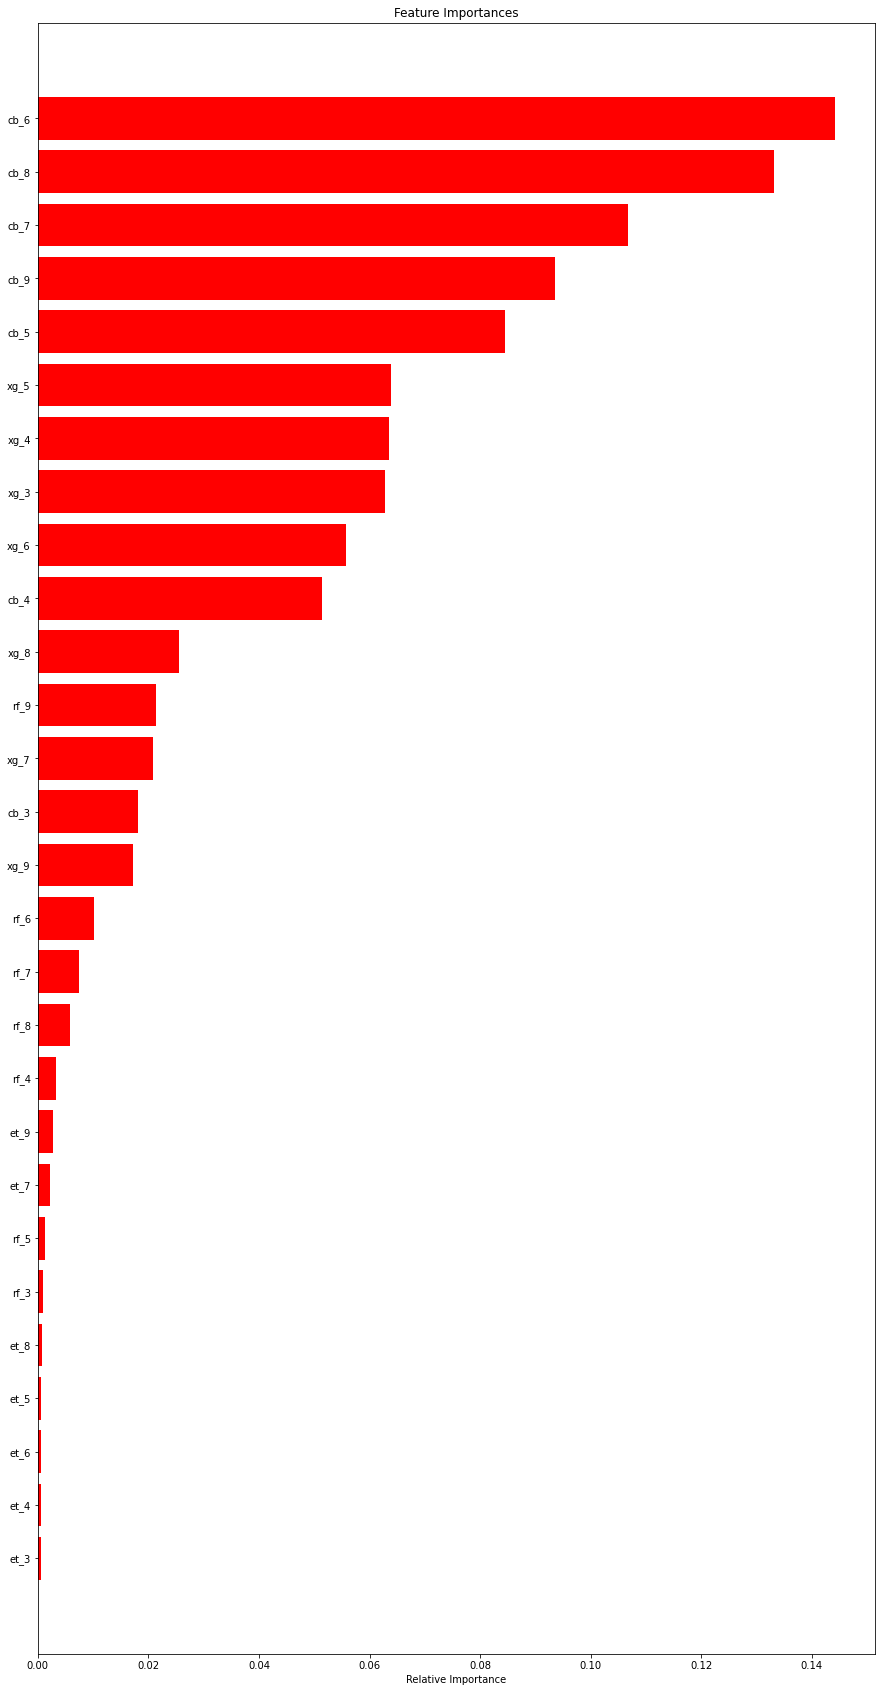

In [119]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r')
plt.yticks(range(len(indices)), [oof_Train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Catboost и XGBoost сделали основной вклад.

**Сохранение результатов**

In [113]:
len(X_test), len(oof_Test)

(19198, 19198)

In [114]:
d = {'POLICY_ID': X_test.index,
     'POLICY_IS_RENEWED': clf.predict(oof_Test),
     'POLICY_IS_RENEWED_PROBABILITY':clf.predict_proba(oof_Test)[:, 1]}

res = pd.DataFrame.from_dict(d)

In [115]:
res

POLICY_ID  POLICY_IS_RENEWED  POLICY_IS_RENEWED_PROBABILITY
0              9                  1                       0.846135
1             11                  1                       0.699753
2             12                  1                       0.702102
3             21                  0                       0.338999
4             36                  1                       0.850763
...          ...                ...                            ...
19193      96573                  1                       0.826934
19194      96576                  1                       0.618478
19195      96585                  1                       0.903628
19196      96594                  1                       0.762838
19197      96597                  1                       0.769209

[19198 rows x 3 columns]

In [116]:
res.to_excel("drive/My Drive/Colab Notebooks/Predictions.xlsx", index = None)

      function ClickConect()  
      {  
        console.log("Working");  
        document.getElementById("file-menu").click();  
      }  
      setInterval(ClickConect, 60000);